# Advanced Statistical Inference
## Bayesian Logistic Regression - Metropolis-Hastings


## 1. Aims
- To implement the MH algorithm.
- To use it to compute classification probabilities.

## 2. Metropolis-Hastings
In this lab, you’re going to implement the Metropolis-Hasting algorithm described in the lecture.
Use the binary classification data `binaryclass2.mat` and the function `laplacecomp()`. If you
pass this function a 2-dimensional $w$ vector, it will return $g(w; X, t, \sigma^2)$ and $log(g(w; X, t, \sigma^2))$.
(Remember that $g(w; X, t, \sigma^2) \propto p(w|X, t, \sigma^2)$, the posterior density of interest.)

## 2.1 
Make sure `laplacecomp()` works by passing it some different $w$ vectors ($w$ needs to have dimension 2×1).

In [1]:
import numpy as np
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import scipy.io
from scipy import stats

In [2]:
data = scipy.io.loadmat('binaryclass2.mat')
X = data['X']
t = data['t']

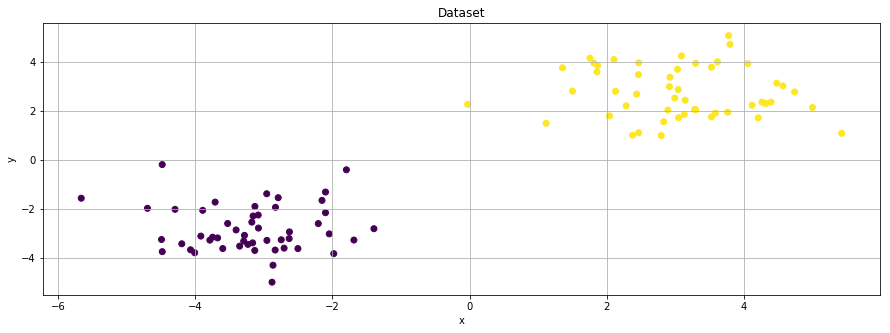

In [3]:
plt.figure(figsize=(15,5))
ax = plt.gca()
plt.title("Dataset")
plt.xlabel("x")
plt.ylabel("y")
ax.scatter(X[:,0], X[:,1], c=t)
plt.grid()
plt.show()

In [4]:
def laplacecomp(w, X, t):
    """Computes g and log g for the laplace model"""
    w = np.array(w)
    X = np.array(X)
    t = np.array(t)
    ss = 10 # Prior variance
    # Evaluate log prior

    logg = -(1/(2*ss))*w.T.dot(w)
    # Compute P
    P = 1/(1+np.exp(-X.dot(w)))
    logl = np.sum(t*np.log(P) + (1-t)*(np.log(1-P)))
    logg = logg + logl
    g = np.exp(logg)
    return g[0][0], logg[0][0]

## 2.2 
Implement the MH algorithm (see the flowchart in the slides). You might find it safest to work with $log(g)$ – the ratio then becomes a subtraction that must then be exponentiated. This has more numerical stability, especially when $w$ isn’t very good. You can start with any value of $w$. E.g., $w = randn(2,1)$. Also, use a Gaussian proposal: For example: $wp = randn(2,1)*0.5+w$ where $w$ is the current sample and $wp$ is the proposal and the Gaussian has standard deviation $0.5$ (set this as you please).

In [11]:
def metropolis(X,t,n_samples=10000):
    ws = list()
    w = np.random.randn(2, 1)
    ws.append(w)
    Sigma_p = np.array([[0.5, 0], [0, 0.5]])
    
    for s in range(n_samples):
        w = ws[s-1]
        wp = np.random.randn(2, 1).T.dot(Sigma_p).T + w # N(mu, sigma)
        # Compute acceptance ratio
        loggwp = laplacecomp(wp, X, t)[1]
        
        logp = np.log(stats.multivariate_normal.pdf(w.reshape(2), mean=wp.reshape(2), cov=Sigma_p))
        
        loggw = laplacecomp(w, X, t)[1]
        logpp = np.log(stats.multivariate_normal.pdf(wp.reshape(2), mean=w.reshape(2), cov=Sigma_p))
        logr = loggwp + logp - loggw - logpp
        r = np.exp(logr)

        if r >= 1:
            ws.append(wp) # acceptance
        else:
            u = np.random.normal(0, 1)
            if u <= r:
                ws.append(wp) # accept
            else:
                ws.append(w) # 
    ws = np.array(ws)
    return ws

In [12]:
numSamples = 10000
w_samples = metropolis(X,t, numSamples)

/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply


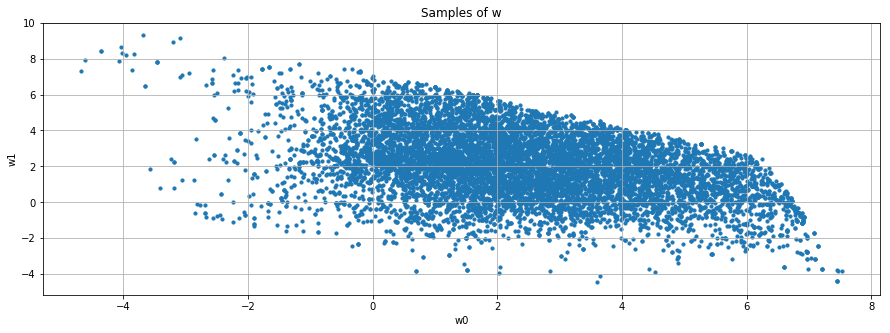

In [18]:
plt.figure(figsize=(15,5))
ax = plt.gca()
ax.scatter(w_samples[:,0], w_samples[:,1], s=10)
plt.title("Samples of w")
plt.xlabel("w0")
plt.ylabel("w1")
plt.grid()
plt.show()

## 2.3 
Compute the probability $P (t_{new} = 1 \mid x_{new} , X, t)$ when $x_{new} = [2,-4]^T$ . Hint – compute the probability for each value of $w$ using:
$ \dfrac{1}{1+\exp(-w^T x_{new})} $

In [14]:
def confidence(w_samples,x):
    x_new = np.array(x)
    p = 0
    for w in w_samples:
        p += 1/(1 + np.exp(-w.T.dot(x_new))) 
    p = p/len(w_samples)
    return p[0]

In [15]:
confidence(w_samples,[2,-4])

0.37432491543478114

In [28]:
x1_range = np.arange(-6, 6.5, 0.5)
x2_range = np.arange(-6, 6.5, 0.5)
probability = []
for x1 in x1_range:
    p_x = []
    for x2 in x2_range:
        x_new = np.array([x1, x2])
        p_x.append(confidence(w_samples, x_new))
    probability.append(p_x)

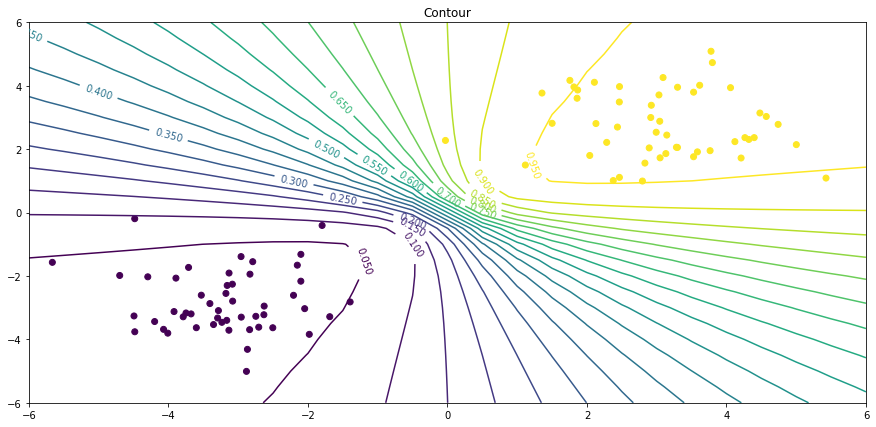

In [30]:
plt.figure(figsize=(15,7))
ax = plt.gca()
num_ines = 20
lines = plt.contour(x1_range, x2_range, p, num_lines)
plt.clabel(lines, inline=1)
ax.scatter(X[:,0], X[:,1], c=t)
plt.title('Contour')
plt.show()